In [ ]:
# ML4DQM Evaluation Test - Simple ViT
# Author: Steaphen

# Import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [ ]:
# Load datasets
file1 = "Run355456_Dataset_jqkne.npy"
file2 = "Run357479_Dataset_iodic.npy"

data1 = np.load(file1)
data2 = np.load(file2)

print("Dataset 1 shape:", data1.shape)
print("Dataset 2 shape:", data2.shape)

Dataset 1 shape: (10000, 64, 72)
Dataset 2 shape: (10000, 64, 72)


In [ ]:
# Prepare labels
labels1 = np.zeros(len(data1))
labels2 = np.ones(len(data2))

# Combine datasets
X = np.concatenate([data1, data2], axis=0)
y = np.concatenate([labels1, labels2], axis=0)

# Normalize
X = X / np.max(X)

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


Train shape: (16000, 64, 72)
Test shape: (4000, 64, 72)


In [ ]:
# Create PyTorch datasets and dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

In [ ]:
# Define a simple ViT-like model (fully connected version)
class SimpleViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(64*72, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.fc(x)


In [ ]:
# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on:", device)

model = SimpleViT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training on: cpu


In [ ]:
# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 3.8448
Epoch 2, Loss: 0.0314
Epoch 3, Loss: 0.0123
Epoch 4, Loss: 0.0051
Epoch 5, Loss: 0.0027


In [ ]:
# Evaluation
model.eval()
y_pred_probs = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = nn.functional.softmax(outputs, dim=1)[:,1]
        y_pred_probs.extend(probs.cpu().numpy())
        y_true.extend(y_batch.numpy())

In [ ]:
# Convert predictions to labels
y_pred_labels = [1 if p>0.5 else 0 for p in y_pred_probs]

accuracy = accuracy_score(y_true, y_pred_labels)
roc_auc = roc_auc_score(y_true, y_pred_probs)

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"ROC AUC Score: {roc_auc:.4f}")

Test Accuracy: 100.00%
ROC AUC Score: 1.0000


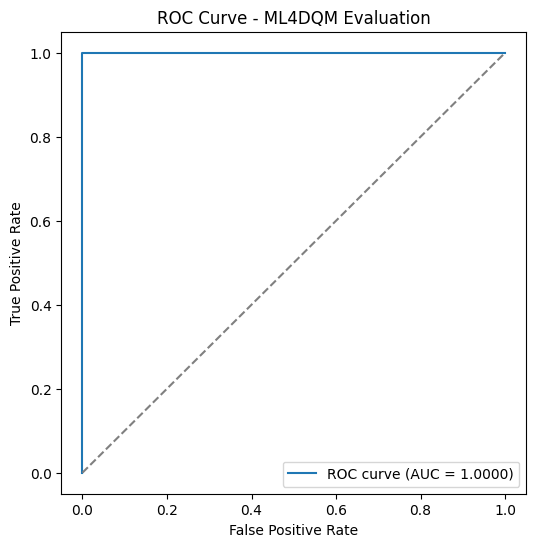

In [ ]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ML4DQM Evaluation")
plt.legend()
plt.show()